# Pneumonia Prediction using Convulational Neural Network
The images trained, tested and validated for the neural network are chest X-Ray images. The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability. Here, I establish a diagnostic tool based on a deep-learning framework for the screening of patients with common treatable blinding retinal diseases.

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 K

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import gradio

Data Preprocessing:

Getting training, validation and testing dataset

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) #reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [ ]:
train = get_data('/content/drive/MyDrive/archive/chest_xray/train')
test = get_data('/content/drive/MyDrive/archive/chest_xray/test')
val = get_data('/content/drive/MyDrive/archive/chest_xray/val')

<ipython-input-3-c95eb64dc460>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Splitting x and y labels of training, validation and testing dataset

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)


In [ ]:
positives = []
negatives = []

for i in range(len(y_train)):
  if y_train[i]:
    positives.append(x_train[i])
  else:
    negatives.append(x_train[i])

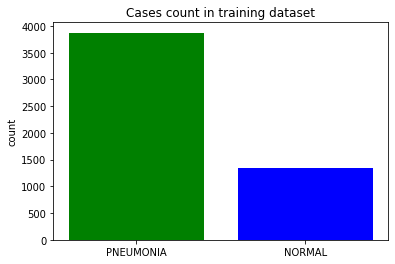

In [ ]:
plt.bar(labels, [len(negatives), len(positives)], color = ["green", "blue"])
plt.title("Cases count in training dataset")
plt.ylabel("count")
plt.show()

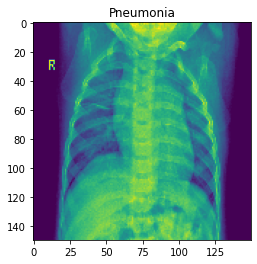

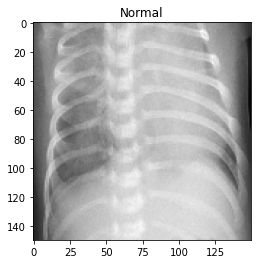

In [ ]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap = 'gray')
plt.title("Normal")
plt.show()

Performing a grayscale normalization to reduce the efffect of illumination differences

In [ ]:
#Normalize the data
x_train = np.array(x_train)/255 #reduce the values only in 0 or 1
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

Resizing the data for CNN training and testing

In [ ]:
#resize data for deep learning

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

# Data augmentation: 
In order to avoid overfitting problem, we can expand artificially our dataset. This can be done by altering the training data with small transformations to reproduce the variations.
Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=30, #randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, #randomly zoom image
        width_shift_range=0.1, #randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, #randomly shift images vertically (fraction of total height)
        horizontal_flip=True, #randomly flip images
        vertical_flip=False) #randomly flip images

datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3) , strides = 1, padding = 'same', activation = 'relu', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(64, (3,3) , strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
